In [34]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
%autoreload 2
import numpy as np
from scipy.linalg import khatri_rao
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [36]:
def gauss(x, r, seed):
    np.random.seed(seed)
    return np.random.normal(size = (x, r))

def gauss_gauss(d, log_emb_size, emb_num, r, seed):
    emb_size = int(d ** log_emb_size)
    embeddings = [gauss(emb_size, r, internal_seed) for internal_seed in range(emb_num * seed, emb_num * (seed + 1))]
    answer = embeddings[0]
    for i in range(1, len(embeddings)):
        answer = khatri_rao(answer, embeddings[i])
    return answer


In [37]:
for p in [1, 2, 3, 4, 6, 12]:
    matr = gauss_gauss(2, 12 // p, p, 12, 0)
    print(matr.shape)

(4096, 12)
(4096, 12)
(4096, 12)
(4096, 12)
(4096, 12)
(4096, 12)


In [38]:
def generate_almost_unit(n, m, noise, seed):
    def inverse_permutation(p):
        p = np.asanyarray(p)
        s = np.empty_like(p)
        s[p] = np.arange(p.size)
        return s

    assert n >= m
    np.random.seed(seed)
    matrix = np.zeros((n, m))
    for i in range(m):
        matrix[i, i] = 1
    noise_matrix = np.random.normal(0, noise, (n, m))
    matrix += noise_matrix
    perm = np.random.permutation(m)
    matrix = matrix[:, perm]
    q, r = np.linalg.qr(matrix, mode='reduced')
    return q[:, inverse_permutation(perm)]

In [39]:
expected = []
variance = []
for base in [1.01, 1.05, 1.18, 1.5, 2]:#, 4.5, 10]:
    n = 64
    u = generate_almost_unit(n, n, 0.1, seed = 0)
    vT = generate_almost_unit(n * n, n, 0.01, seed=0).T
    sigma = np.logspace(3, 4 - n, base=base, num=n)
    A = u @ np.diag(sigma) @ vT

    for p in [1, 2, 3, 4, 6, 12]:
        log_emb_size, emb_num = 12 // p, p
        for r in [7, 12, 17, 22, 27, 32, 37, 42]:#, 47, 52, 57, 62, 67]:
            precisions = []
            for seed in range(1, 2001):
                Omega = gauss_gauss(2, log_emb_size, emb_num, r, seed)
                Q, R = np.linalg.qr(A @ Omega)
                B = Q @ (Q.T @ A)
                C = u[:,:r] @ np.diag(sigma[:r]) @ vT[:r, :]
                precisions.append(np.linalg.norm(A - B) ** 2 / np.linalg.norm(A - C) ** 2)
            precisions = np.array(precisions)
            name = f"{log_emb_size}_{emb_num}"
            expected.append((r, precisions.mean(), name, base))
            variance.append((r, precisions.var(), name, base))
df_expected = pd.DataFrame(expected, columns=["rank", "precision", "generator_name", "base"])
df_variance = pd.DataFrame(variance, columns=["rank", "precision", "generator_name", "base"])

Base =  1.01


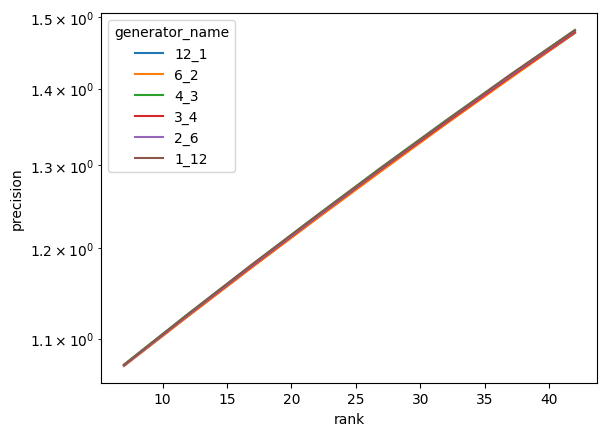

Base =  1.05


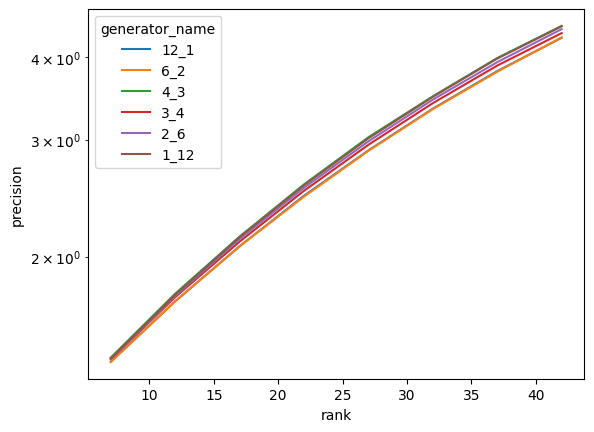

Base =  1.18


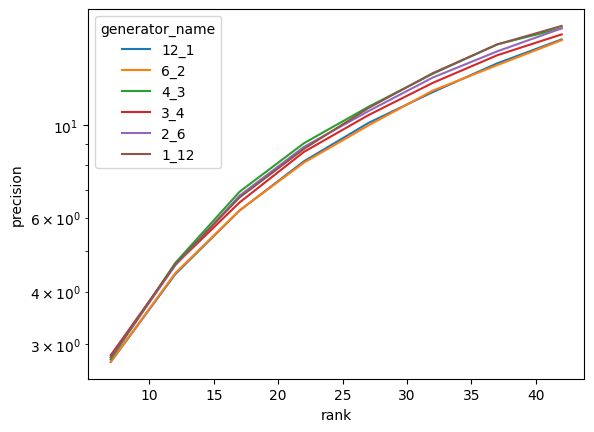

Base =  1.5


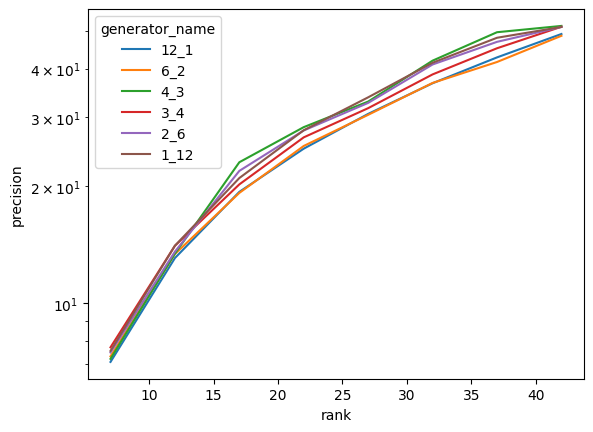

Base =  2


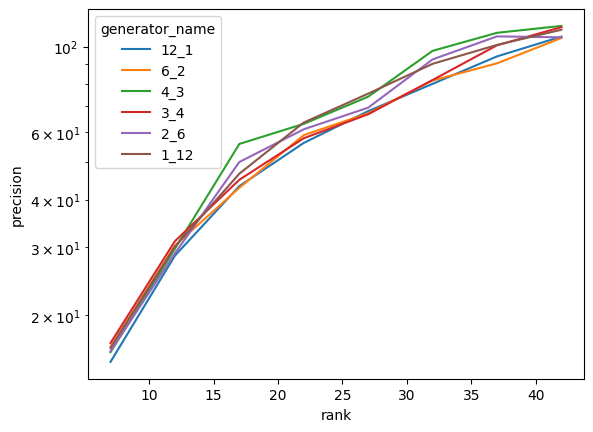

In [40]:
for base in [1.01, 1.05, 1.18, 1.5, 2]:
    print("Base = ", base)
    fig, ax = plt.subplots(1, 1)
    sns.lineplot(data=df_expected[df_expected["base"] == base], x='rank', y='precision', hue='generator_name', ax=ax)
    ax.set_yscale('log')
    plt.show()

Base =  1.01


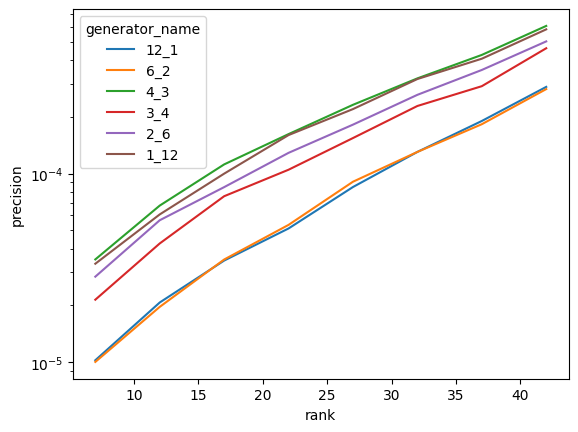

Base =  1.05


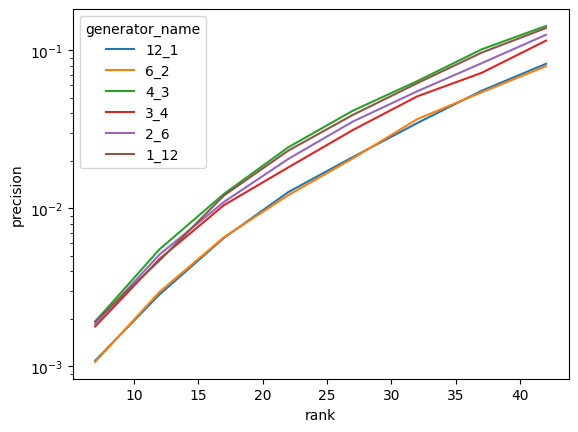

Base =  1.18


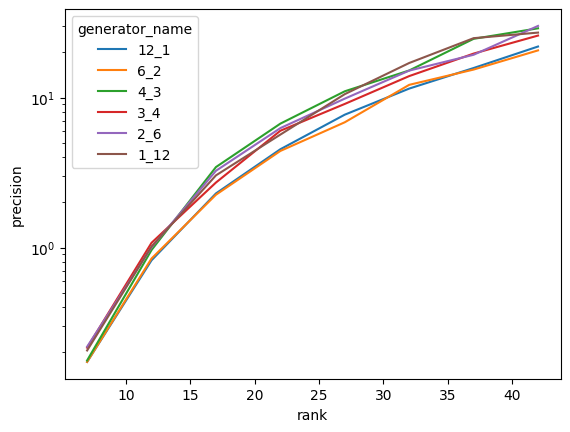

Base =  1.5


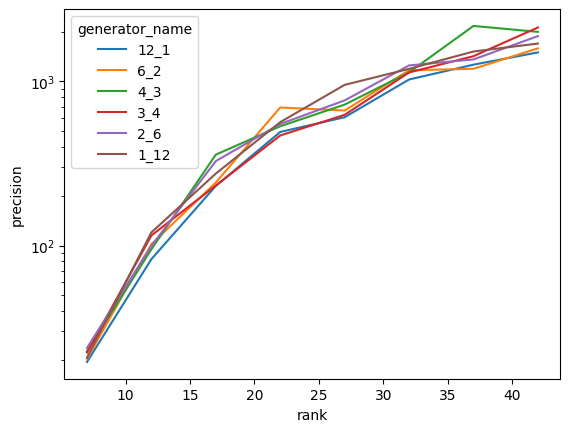

Base =  2


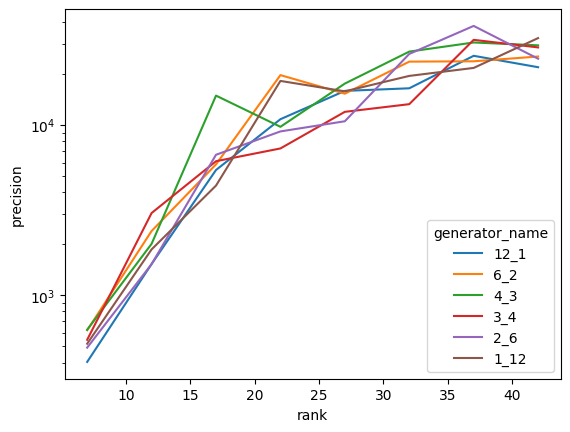

In [42]:
for base in [1.01, 1.05, 1.18, 1.5, 2]:
    print("Base = ", base)
    fig, ax = plt.subplots(1, 1)
    sns.lineplot(data=df_variance[df_variance["base"] == base], x='rank', y='precision', hue='generator_name', ax=ax)
    ax.set_yscale('log')
    plt.show()

In [41]:
df_expected.to_csv('../experiments_results/experiment2/expected.csv')
df_variance.to_csv('../experiments_results/experiment2/variance.csv')